# Data playgound for Contrails Forecasting

In [30]:
import numpy as np
import pandas as pd
import xarray as xr
import sympy 
import cfgrib
import eccodes
import os

In [ ]:
import cdsapi

dataset = "reanalysis-era5-pressure-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "divergence",
        "fraction_of_cloud_cover",
        "geopotential",
        "ozone_mass_mixing_ratio",
        "potential_vorticity",
        "relative_humidity",
        "specific_cloud_ice_water_content",
        "specific_cloud_liquid_water_content",
        "specific_humidity",
        "specific_rain_water_content",
        "specific_snow_water_content",
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "vertical_velocity",
        "vorticity"
    ],
    "year": ["2024"],
    "month": ["11"],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "pressure_level": [
        "200", "225", "250",
        "300"
    ],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [50, -120, 30, -80]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


In [31]:
ds = xr.open_dataset('./data/2024_11.grib',engine='cfgrib')
# Convert the xarray Dataset to a pandas DataFrame
df = ds.to_dataframe().reset_index()

In [32]:
# Display the first 10 rows of the DataFrame
print(df.head(1).to_string(index=False))

      time  isobaricInhPa  latitude  longitude  number   step valid_time        d  cc         z           o3       pv        r  ciwc  clwc        q  crwc  cswc          t         u         v        w       vo
2024-11-01          300.0      50.0     -120.0       0 0 days 2024-11-01 0.000009 0.0 87420.625 3.100554e-07 0.000006 9.371011   0.0   0.0 0.000012   0.0   0.0 226.384003 -8.055939 13.610977 0.089255 0.000167


In [54]:
df.shape

(37558080, 23)

In [42]:
def percentage_zero_or_null(df):
    result = pd.DataFrame(index=df.columns, columns=['percent_zero_or_null'])
    
    for col in df.columns:
        total = len(df)
        zero_or_null_count = ((df[col] == 0) | (df[col].isnull())).sum()
        result.loc[col, 'percent_zero_or_null'] = 100 * zero_or_null_count / total
        
    return result

In [43]:
percentage_zero_or_null(df)

,percent_zero_or_null
time,0.0
isobaricInhPa,0.0
latitude,0.0
longitude,0.0
number,100.0
step,0.0
valid_time,0.0
d,0.000197
cc,76.844498
z,0.0


In [51]:

def column_summary(df, columns):
    # Ensure input is a list
    if isinstance(columns, str):
        columns = [columns]
    
    summaries = {}

    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")

        series = df[col]
        summaries[col] = {
            'count': series.count(),
            'missing': series.isnull().sum(),
            'mean': series.mean(),
            'std': series.std(),
            'min': series.min(),
            '25% (Q1)': series.quantile(0.25),
            '50% (Median)': series.median(),
            '75% (Q3)': series.quantile(0.75),
            'max': series.max()
        }

    return pd.DataFrame.from_dict(summaries, orient='index')


In [53]:
column_summary(df, ['cc','ciwc', 'clwc','crwc','cswc'])

,count,missing,mean,std,min,25% (Q1),50% (Median),75% (Q3),max
cc,37558080,0,9.011917e-02,2.243361e-01,0.0,0.0,0.0,0.0,1.000000e+00
ciwc,37558080,0,3.036428e-06,1.804932e-05,0.0,0.0,0.0,0.0,1.281738e-03
clwc,37558080,0,1.449071e-09,3.748373e-07,0.0,0.0,0.0,0.0,3.987551e-04
crwc,37558080,0,3.904145e-14,6.556174e-11,0.0,0.0,0.0,0.0,2.234592e-07
cswc,37558080,0,9.551165e-07,1.272417e-05,0.0,0.0,0.0,0.0,5.337477e-03


In [97]:
import numpy as np

def add_rhi_column(df):
    """
    Adds Relative Humidity with respect to ice (RHi) to the DataFrame.
    Assumes input columns:
        - q: specific humidity (kg/kg)
        - t: temperature (K)
        - isobaricInhPa: pressure level (hPa)
    Returns:
        Modified DataFrame with an added 'RHi' column (%)
    """
    # Physical constants
    Rd = 287.05       # J/(kg·K) - gas constant for dry air
    Rv = 461.5        # J/(kg·K) - gas constant for water vapor
    epsilon = Rd / Rv # ~0.622
    
    # Extract variables
    q = df['q'].values
    T = df['t'].values
    p = df['isobaricInhPa'].values * 100  # Convert hPa to Pa

    # Saturation vapor pressure over ice (in Pa) using Sonntag (1994)
    es_ice = np.exp(9.550426 - (5723.265 / T) + 3.53068 * np.log(T) - 0.00728332 * T)

    # Saturation specific humidity over ice
    q_si = epsilon * es_ice / (p - (1 - epsilon) * es_ice)

    # RHi in %
    RHi = (q / q_si) * 100
    df['RHi'] = RHi

    return df


In [98]:
df = add_rhi_column(df)

In [99]:
df.dtypes

time              datetime64[ns]
isobaricInhPa            float64
latitude                 float64
longitude                float64
number                     int64
step             timedelta64[ns]
valid_time        datetime64[ns]
d                        float32
cc                       float32
z                        float32
o3                       float32
pv                       float32
r                        float32
ciwc                     float32
clwc                     float32
q                        float32
crwc                     float32
cswc                     float32
t                        float32
u                        float32
v                        float32
w                        float32
vo                       float32
RHi                      float64
dtype: object

In [120]:
df.shape

(37558080, 24)

In [119]:
df[df['RHi'] >= 100].shape

(3300718, 24)

In [100]:
from scipy.stats import pearsonr
import pandas as pd

def detailed_correlation_with_targets(df, targets):
    if isinstance(targets, str):
        targets = [targets]  # allow single string input

    results = []
    feature_cols = [col for col in df.columns if col not in targets]

    for target in targets:
        for feature in feature_cols:
            valid = df[[feature, target]].dropna()
            if len(valid) > 1:  # Need at least 2 points to compute correlation
                corr, pval = pearsonr(valid[feature], valid[target])
                results.append({
                    'Feature': feature,
                    'Target': target,
                    'Correlation': corr,
                    'P-value': pval,
                    'N': len(valid)
                })

    return pd.DataFrame(results).sort_values(by=['Target', 'Correlation'], ascending=[True, False])


In [101]:
df2 = df.drop(['time','isobaricInhPa','latitude','longitude','number','step','valid_time'],axis =1)

In [102]:
from scipy.stats import pearsonr

def detailed_correlation_with_target(df, target):
    results = []
    for col in df.columns:
        if col == target:
            continue
        valid = df[[col, target]].dropna()
        corr, pval = pearsonr(valid[col], valid[target])
        results.append((col, corr, pval, len(valid)))
    
    return pd.DataFrame(results, columns=['Variable', 'Correlation', 'P-value', 'N']).sort_values(by='Correlation', ascending=False)


In [103]:
df2.dtypes

d       float32
cc      float32
z       float32
o3      float32
pv      float32
r       float32
ciwc    float32
clwc    float32
q       float32
crwc    float32
cswc    float32
t       float32
u       float32
v       float32
w       float32
vo      float32
RHi     float64
dtype: object

In [104]:
res = detailed_correlation_with_target(df2,'r')

In [105]:
print(res.to_string(index=False))

Variable  Correlation       P-value        N
     RHi     0.999892  0.000000e+00 37558080
      cc     0.595588  0.000000e+00 37558080
       q     0.532779  0.000000e+00 37558080
    ciwc     0.247848  0.000000e+00 37558080
       u     0.222424  0.000000e+00 37558080
       d     0.131023  0.000000e+00 37558080
    cswc     0.107752  0.000000e+00 37558080
    clwc     0.006368  0.000000e+00 37558080
    crwc     0.000959  4.246965e-09 37558080
       v    -0.006039 8.593338e-300 37558080
       z    -0.081128  0.000000e+00 37558080
       w    -0.112129  0.000000e+00 37558080
       t    -0.244260  0.000000e+00 37558080
      vo    -0.534742  0.000000e+00 37558080
      o3    -0.565918  0.000000e+00 37558080
      pv    -0.617811  0.000000e+00 37558080


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, target, method='pearson'):
    corr = df.corr(method=method)[[target]].drop(index=target).sort_values(by=target, ascending=False)
    
    plt.figure(figsize=(6, len(corr)*0.5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title(f'Correlation with {target}')
    plt.tight_layout()
    plt.show()


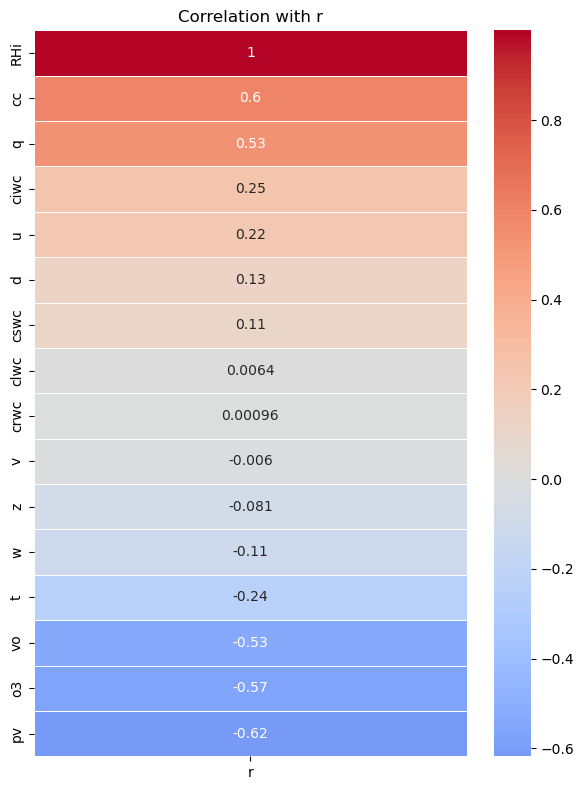

In [106]:
plot_correlation_heatmap(df2,'r',method='pearson')

In [107]:
res = detailed_correlation_with_target(df2,'q')

In [108]:
print(res.to_string(index=False))

Variable  Correlation  P-value        N
       r     0.532779      0.0 37558080
     RHi     0.532748      0.0 37558080
       t     0.500854      0.0 37558080
      cc     0.402908      0.0 37558080
    ciwc     0.385545      0.0 37558080
    cswc     0.283618      0.0 37558080
       v     0.112493      0.0 37558080
       d     0.074737      0.0 37558080
       u     0.053492      0.0 37558080
    clwc     0.037525      0.0 37558080
    crwc     0.007889      0.0 37558080
       w    -0.157195      0.0 37558080
      vo    -0.350940      0.0 37558080
       z    -0.403441      0.0 37558080
      o3    -0.419784      0.0 37558080
      pv    -0.473446      0.0 37558080


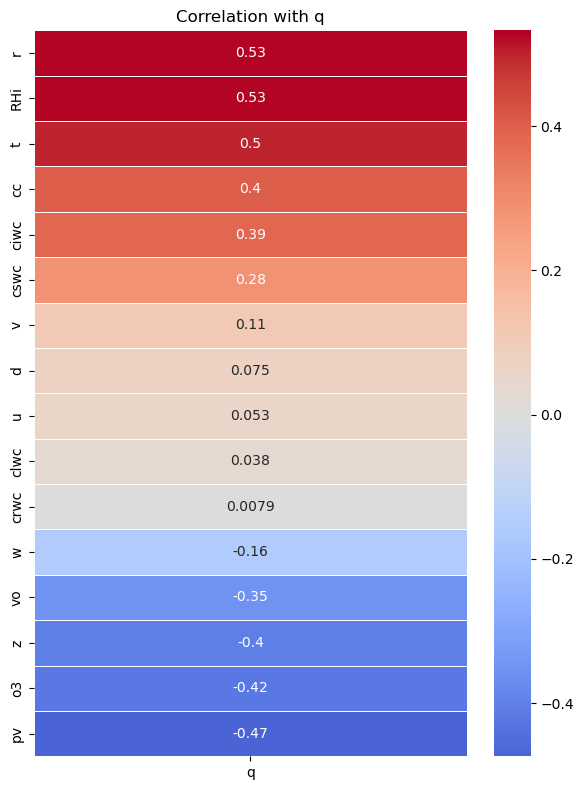

In [109]:
plot_correlation_heatmap(df2,'q',method='pearson')

In [121]:
res = detailed_correlation_with_target(df2,'RHi')

In [122]:
print(res.to_string(index=False))

Variable  Correlation       P-value        N
       r     0.999892  0.000000e+00 37558080
      cc     0.597246  0.000000e+00 37558080
       q     0.532748  0.000000e+00 37558080
    ciwc     0.248393  0.000000e+00 37558080
       u     0.222775  0.000000e+00 37558080
       d     0.130914  0.000000e+00 37558080
    cswc     0.107868  0.000000e+00 37558080
    clwc     0.006359  0.000000e+00 37558080
    crwc     0.000955  4.867049e-09 37558080
       v    -0.005540 1.253478e-252 37558080
       z    -0.081330  0.000000e+00 37558080
       w    -0.112420  0.000000e+00 37558080
       t    -0.243510  0.000000e+00 37558080
      vo    -0.534494  0.000000e+00 37558080
      o3    -0.566390  0.000000e+00 37558080
      pv    -0.618642  0.000000e+00 37558080


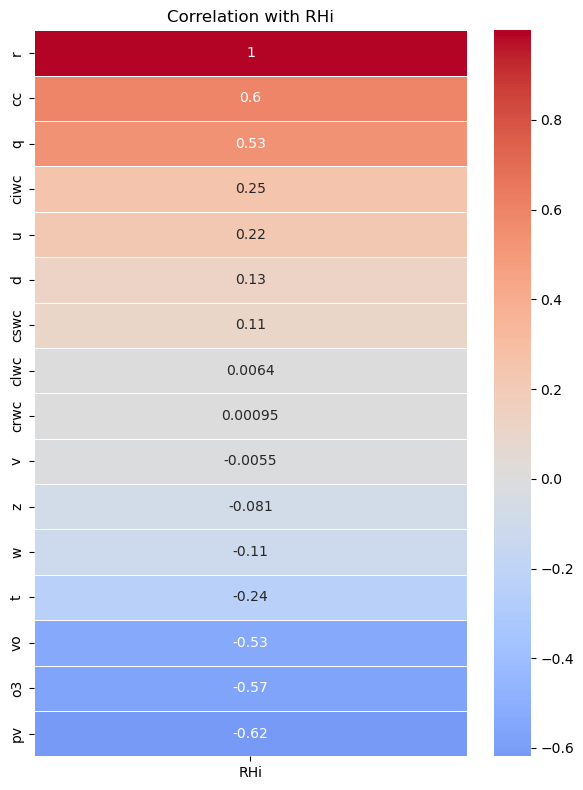

In [123]:
plot_correlation_heatmap(df2,'RHi',method='pearson')

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multi_target_heatmap(df, targets, method='pearson'):
    corr = df.corr(method=method)[targets].drop(index=targets)
    
    plt.figure(figsize=(len(targets) * 2.5, len(corr) * 0.5 + 1))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Correlation with Multiple Targets')
    plt.tight_layout()
    plt.show()


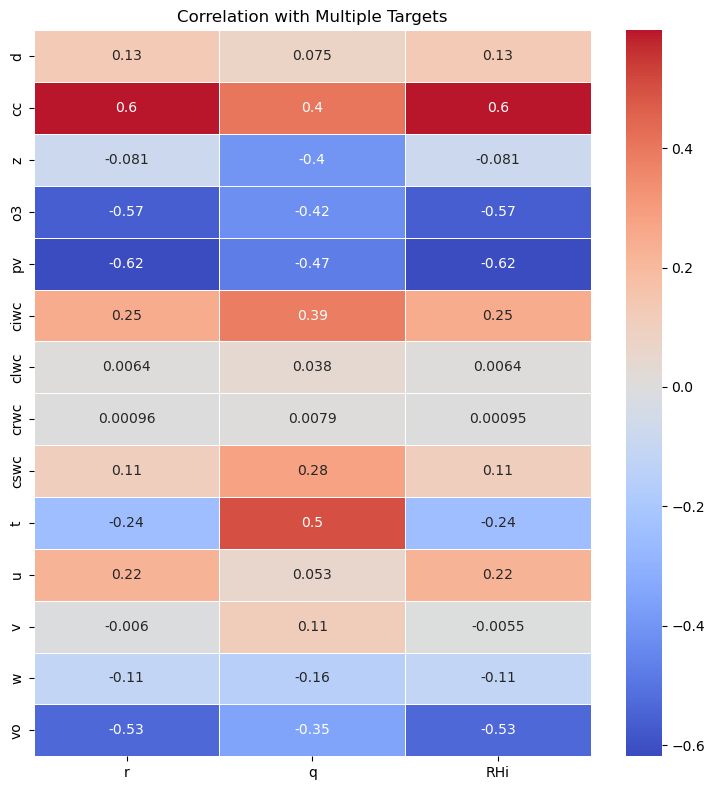

In [124]:
plot_multi_target_heatmap(df2,['r','q','RHi'])

In [ ]:
df = df.rename(columns={'d':'divergence',
                        'cc':'cloud_cover',
                        'z':'geopotential',
                        'o3':'ozone_concentration',
                        'pv':'potential_vorticity',
                        'r':'rel_humidity',
                        'ciwc':'cloud_ice_water_content',
                        'clwc':'cloud_liquid_water_content',
                        'q':'specific_humidity',
                        'crwc':'cloud_rain_water_content',
                        'cswc':'cloud_snow_water_content',
                        't':'temperature',
                        'u':'wind_speed_east',
                        'v':'wind_speed_north',
                        'w':'verticle_wind_speed',
                        'vo':'rel_vorticity'})

        time  isobaricInhPa  latitude  longitude  number   step valid_time  \
0 2024-01-01          350.0      90.0       0.00       0 0 days 2024-01-01   
1 2024-01-01          350.0      90.0       0.25       0 0 days 2024-01-01   
2 2024-01-01          350.0      90.0       0.50       0 0 days 2024-01-01   
3 2024-01-01          350.0      90.0       0.75       0 0 days 2024-01-01   
4 2024-01-01          350.0      90.0       1.00       0 0 days 2024-01-01   
5 2024-01-01          350.0      90.0       1.25       0 0 days 2024-01-01   
6 2024-01-01          350.0      90.0       1.50       0 0 days 2024-01-01   
7 2024-01-01          350.0      90.0       1.75       0 0 days 2024-01-01   
8 2024-01-01          350.0      90.0       2.00       0 0 days 2024-01-01   
9 2024-01-01          350.0      90.0       2.25       0 0 days 2024-01-01   

     divergence  cloud_cover  geopotential  ...  cloud_ice_water_content  \
0 -2.023298e-07          0.0      73315.75  ...                  

In [8]:
print(df.head(100).to_string(index=False))


      time  isobaricInhPa  latitude  longitude  number   step valid_time    divergence  cloud_cover  geopotential  ozone_concentration  potential_vorticity  rel_humidity  cloud_ice_water_content  cloud_liquid_water_content  specific_humidity  cloud_rain_water_content  cloud_snow_water_content  temperature  wind_speed_east  wind_speed_north  verticle_wind_speed  rel_vorticity
2024-01-01          350.0      90.0       0.00       0 0 days 2024-01-01 -2.023298e-07          0.0      73315.75         1.003749e-07             0.000001     73.233162                      0.0                         0.0           0.000032                       0.0                       0.0   217.377991         0.000885         -0.000427            -0.004172       0.000022
2024-01-01          350.0      90.0       0.25       0 0 days 2024-01-01 -2.023298e-07          0.0      73315.75         1.003749e-07             0.000001     73.233162                      0.0                         0.0           0.000032   

In [12]:
!pip install openpyxl

In [13]:
# Select the first 100 rows of the DataFrame
df_100 = df.head(100)

# Export to an Excel file
output_path = './output_100_rows.xlsx'  # Specify the output file path
df_100.to_excel(output_path, index=False)

<xarray.Dataset> Size: 6GB
Dimensions:        (time: 24, isobaricInhPa: 4, latitude: 721, longitude: 1440)
Coordinates:
    number         int64 8B ...
  * time           (time) datetime64[ns] 192B 2024-01-01 ... 2024-01-01T23:00:00
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 32B 350.0 250.0 200.0 150.0
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time     (time) datetime64[ns] 192B ...
Data variables: (12/16)
    d              (time, isobaricInhPa, latitude, longitude) float32 399MB ...
    cc             (time, isobaricInhPa, latitude, longitude) float32 399MB ...
    z              (time, isobaricInhPa, latitude, longitude) float32 399MB ...
    o3             (time, isobaricInhPa, latitude, longitude) float32 399MB ...
    pv             (time, isobaricInhPa, latitude, longitude) float32 399MB ...
    r              (

In [4]:
print(ds.info())

xarray.Dataset {
dimensions:
	time = 24 ;
	isobaricInhPa = 4 ;
	latitude = 721 ;
	longitude = 1440 ;

variables:
	int64 number() ;
		number:long_name = ensemble member numerical id ;
		number:units = 1 ;
		number:standard_name = realization ;
	datetime64[ns] time(time) ;
		time:long_name = initial time of forecast ;
		time:standard_name = forecast_reference_time ;
	timedelta64[ns] step() ;
		step:long_name = time since forecast_reference_time ;
		step:standard_name = forecast_period ;
	float64 isobaricInhPa(isobaricInhPa) ;
		isobaricInhPa:long_name = pressure ;
		isobaricInhPa:units = hPa ;
		isobaricInhPa:positive = down ;
		isobaricInhPa:stored_direction = decreasing ;
		isobaricInhPa:standard_name = air_pressure ;
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:stored_direction = decreasing ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name

In [6]:

timestamps = ds.time[1]
data_at_time = ds.sel(time=timestamps)
df = data_at_time.to_dataframe()
df = df.rename(columns={'d':'divergence',
                        'cc':'cloud_cover',
                        'z':'geopotential',
                        'o3':'ozone_concentration',
                        'pv':'potential_vorticity',
                        'r':'rel_humidity',
                        'ciwc':'cloud_ice_water_content',
                        'clwc':'cloud_liquid_water_content',
                        'q':'specific_humidity',
                        'crwc':'cloud_rain_water_content',
                        'cswc':'cloud_snow_water_content',
                        't':'temperature',
                        'u':'wind_speed_east',
                        'v':'wind_speed_north',
                        'w':'verticle_wind_speed',
                        'vo':'rel_vorticity'})
print(df.head(10))
for col in df.columns:
    print(col)


                                  number                time   step  \
isobaricInhPa latitude longitude                                      
350.0         90.0     0.00            0 2024-01-01 01:00:00 0 days   
                       0.25            0 2024-01-01 01:00:00 0 days   
                       0.50            0 2024-01-01 01:00:00 0 days   
                       0.75            0 2024-01-01 01:00:00 0 days   
                       1.00            0 2024-01-01 01:00:00 0 days   
                       1.25            0 2024-01-01 01:00:00 0 days   
                       1.50            0 2024-01-01 01:00:00 0 days   
                       1.75            0 2024-01-01 01:00:00 0 days   
                       2.00            0 2024-01-01 01:00:00 0 days   
                       2.25            0 2024-01-01 01:00:00 0 days   

                                          valid_time  divergence  cloud_cover  \
isobaricInhPa latitude longitude                                  

In [7]:
print(df.head(10))


                                  number                time   step  \
isobaricInhPa latitude longitude                                      
350.0         90.0     0.00            0 2024-01-01 01:00:00 0 days   
                       0.25            0 2024-01-01 01:00:00 0 days   
                       0.50            0 2024-01-01 01:00:00 0 days   
                       0.75            0 2024-01-01 01:00:00 0 days   
                       1.00            0 2024-01-01 01:00:00 0 days   
                       1.25            0 2024-01-01 01:00:00 0 days   
                       1.50            0 2024-01-01 01:00:00 0 days   
                       1.75            0 2024-01-01 01:00:00 0 days   
                       2.00            0 2024-01-01 01:00:00 0 days   
                       2.25            0 2024-01-01 01:00:00 0 days   

                                          valid_time  divergence  cloud_cover  \
isobaricInhPa latitude longitude                                  